In [40]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()



In [8]:
import json
import shutil
import os
from matplotlib import pyplot as plt

def get_bbox(feature):
    '''
    IN: feature from xview geojson
    OUT: int bbox of form [x1, y1, w,h]
    '''
    # Pull out xview pixel box, convert all value to integers
    box = feature['properties']['bounds_imcoords'].split(',')
    box = [int(b) for b in box]
    [x1, y1, x2, y2] = box.copy()
    
    # Calculate width, height
    w = x2 - x1
    h = y2 - y1
    
    return [x1, y1, w, h]

def get_bbox_geos(feature):
    '''
    IN: feature from xview geojson
    OUT: float bbox of form [lat1, long1, w,h]
    '''
    
    # Pull out list of geocoordinate points
    coords = feature['geometry']['coordinates']
    
    # Make lists of lats and longs 
    lats = []
    longs = []
    for c in coords[0]:
        lats.append(c[0])
        longs.append(c[1])
    
    # Pull out smallest and largest values
    lat_1 = min(lats)
    lat_2 = max(lats)
    long_1 = min(longs)
    long_2 = max(longs)
    
    # Calculate width, height
    w = lat_2 - lat_1
    h = long_2 - long_1
    
    return [lat_1, long_1, w, h]

import imagesize

def get_images(image_folder):
    '''
    IN: image folder where images you want in your coco .json are stored
    OUT: coco style 'images' section
    '''
    
    images = []
    imgs = [image_folder + i for i in os.listdir(image_folder)]
        
    print("Found {} images in folder".format(len(imgs)))
    count = 0
    
    for i in imgs:
        w, h = imagesize.get(i)        
        im_id = int(i.split('/')[-1].split('.')[0])
        
        image = {
            "id" : im_id,
            "width" : w,
            "height": h,
            "file_name": i.split('/')[-1],
            "license": 1
        }
        
        images.append(image)
        count += 1
        if count % 50 == 0:
            print(count, "images processed")
        
        
    return images

LABEL_TO_STRING = {
    11: "Fixed-wing Aircraft",
    12: "Small Aircraft",
    13: "Passenger/Cargo Plane",
    15: "Helicopter",
    17: "Passenger Vehicle",
    18: "Small Car",
    19: "Bus",
    20: "Pickup Truck",
    21: "Utility Truck",
    23: "Truck",
    24: "Cargo Truck",
    25: "Truck Tractor w/ Box Trailer",
    26: "Truck Tractor",
    27: "Trailer",
    28: "Truck Tractor w/ Flatbed Trailer",
    29: "Truck Tractor w/ Liquid Tank",
    32: "Crane Truck",
    33: "Railway Vehicle",
    34: "Passenger Car",
    35: "Cargo/Container Car",
    36: "Flat Car",
    37: "Tank car",
    38: "Locomotive",
    40: "Maritime Vessel",
    41: "Motorboat",
    42: "Sailboat",
    44: "Tugboat",
    45: "Barge",
    47: "Fishing Vessel",
    49: "Ferry",
    50: "Yacht",
    51: "Container Ship",
    52: "Oil Tanker",
    53: "Engineering Vehicle",
    54: "Tower crane",
    55: "Container Crane",
    56: "Reach Stacker",
    57: "Straddle Carrier",
    59: "Mobile Crane",
    60: "Dump Truck",
    61: "Haul Truck",
    62: "Scraper/Tractor",
    63: "Front loader/Bulldozer",
    64: "Excavator",
    65: "Cement Mixer",
    66: "Ground Grader",
    71: "Hut/Tent",
    72: "Shed",
    73: "Building",
    74: "Aircraft Hangar",
    76: "Damaged Building",
    77: "Facility",
    79: "Construction Site",
    83: "Vehicle Lot",
    84: "Helipad",
    86: "Storage Tank",
    89: "Shipping container lot",
    91: "Shipping Container",
    93: "Pylon",
    94: "Tower",
}

def get_categories():
    '''
    OUT: coco gt 'categories' section
    '''
    categories = []
    # Add a category for each line in txt file
    for k, v in LABEL_TO_STRING.items():
        category = {
            "supercategory" : "None",
            "name" : v,
            "id" : k
        }
        categories.append(category)
    
    return categories

def get_annotations(geojson_path):
    '''
    IN: xview geojson
    OUT: coco gt 'annotations' section
    '''
    annotations = []
    
    # Open gejson
    with open(geojson_path, 'r') as f:
        xview = json.load(f)
    
    # Pull features section out
    features = xview['features']
    
    # int to assign to each new annotation sequentially
    id_count = 0
    
    # Process each xview feature
    for f in features:
        # Get bounding box, pixels
        bbox = get_bbox(f)
        
        # Calculate area in pixels
        area = bbox[2] * bbox[3]
        
        # Get bbox, geos
        bbox_geos = get_bbox_geos(f)
        
        # Find the id of the category of this annotation
        cat_id = f['properties']['type_id']
        
        # Assign an image id based on the image file name
        im_id = int(f['properties']['image_id'].split('.')[0])
        
        # Populate new annotation and add it to the main variable 
        ann = {
            "id": id_count, 
            "image_id": im_id, 
            "category_id": cat_id, 
            "area": area, 
            "bbox": bbox, 
            "bbox_geos" : bbox_geos,
            "iscrowd": 0  
        }
        annotations.append(ann)
        id_count += 1
    
    return annotations

def clip_bboxes_to_ims(json_path):
    '''
    PURPOSE: Modify annotations with negative pixel coordinates or coordinates outside the imge they're on, since xview is a whole disaster of a dataset
    IN: path to gt coco json
    '''
    # Open the file
    with open(json_path, 'r') as f:
        gt = json.load(f)

    images = gt['images']

    new_annotations = []
    
    #Tracking
    low = 0
    high = 0
    removed = 0
    
    #Process each annotation one by one
    for a in gt['annotations']:
        
        # Key annotation information
        b = a['bbox']
        new_b = b.copy()
        im_id = a['image_id']
        
        # Process annotations with negative bbox values
        if b[0] < 0 or b[1] < 0:
            if b[0] < 0:
                new_b[0] = 0
                new_b[2] = b[2] + b[0]
            if b[1] < 0:
                new_b[1] = 0
                new_b[3] = b[3] + b[1]
            low += 1
        
        # Check for annotations with annotations too large for image
        for i in images:
            if i['id'] == im_id:
                w = i['width']
                h = i['height']

                if (b[0] + b[2]) > w or (b[1] + b[3]) > h:
                    if (b[0] + b[2]) > w:
                        new_b[2] = w - b[0]
                    if (b[1] + b[3]) > h:
                        new_b[3] = h - b[1]
                    high += 1
        
        # Check to see if the annotations that were off-image were totally off-image
        if new_b[2] > 0 and new_b[3] > 0:
            new_a = a.copy()
            new_a['bbox'] = new_b
            new_annotations.append(new_a)
        else:
            removed += 1


    new_gt = gt.copy()
    new_gt['annotations'] = new_annotations
    
    # Delete old json and save out new annotations
    os.remove(json_path)

    with open(json_path, 'w') as f:
        json.dump(new_gt, f)
        
    print("Corrected {} boxes with coords below 0 and {} with coords larger than image".format(low, high))
    print('Removed', removed, 'annotations')
    return

def make_json(geojson_path, image_folder):
    '''
    PURPOSE: translate xview geojson to coco gt file
    IN:
        - geojson_path: path to xview geojson
        - image_folder: folder of images for these annotations
    OUT: path to new coco json
    '''
    # Open geojson
    with open(geojson_path, 'r') as f:
        xview = json.load(f)
    
    # Create new path to save to
    new_path = geojson_path.replace('.geojson', '.json')
    
    # Populate main 5 coco json fields
    # First 2 are simple, so no function
    licenses = [{"id": 1, "name": "xView"}]
    info = {"year": '2018', "version": '1', "description": 'xView', "contributor": 'DIUx', "date_created": "03/17/2020"}
    # Refer to functions above
    images = get_images(image_folder)
    print('All images processed')
    categories = get_categories()
    annotations = get_annotations(geojson_path)
    print('JSON sections complete')
    
    # Create final structure 
    coco_json = {
        'info' : info,
        'licenses' : licenses,
        'images' : images,
        'categories' : categories,
        'annotations' : annotations
    }
    
    # Ensure no funny business with save
    if os.path.exists(new_path):
        os.remove(new_path)
    
    # Save file
    with open(new_path, 'w') as f:
        json.dump(coco_json, f)
    
    print('Part 1 complete')
    
    clip_bboxes_to_ims(new_path)
    
    # Feedback
    print('New json', new_path)
    
    return new_path

In [9]:
make_json(geojson_path='/data/XVIEW1/xView_train.geojson', image_folder='/data/XVIEW1/train_images/')

Found 846 images in folder
50 images processed
100 images processed
150 images processed
200 images processed
250 images processed
300 images processed
350 images processed
400 images processed
450 images processed
500 images processed
550 images processed
600 images processed
650 images processed
700 images processed
750 images processed
800 images processed
All images processed
JSON sections complete
Part 1 complete
Corrected 5073 boxes with coords below 0 and 4941 with coords larger than image
Removed 32 annotations
New json /data/XVIEW1/xView_train.json


'/data/XVIEW1/xView_train.json'

In [59]:
from torchvision.datasets import VisionDataset
from PIL import Image
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from collections import defaultdict

def list_of_dicts_to_dict_of_lists(list_of_dicts):
    dict_of_lists = defaultdict(list)
    for dct in list_of_dicts:
        for key, value in dct.items():
            dict_of_lists[key].append(value)
    return dict(dict_of_lists)

class xView(VisionDataset):
    """
    Requires the `COCO API to be installed <https://github.com/pdollar/coco/tree/master/PythonAPI>`_.

    Args:
        root (str or ``pathlib.Path``): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
    """

    def __init__(self, root, annFile, merge=None, transforms=None):
        super().__init__(root)
        self.transforms = transforms
        from pycocotools.coco import COCO
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id: int):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int):
        id = self.ids[index]
        tv_image = tv_tensors.Image(self._load_image(id))
        target = self._load_target(id)
        target = list_of_dicts_to_dict_of_lists(target)
        tv_target = {}
        tv_target["boxes"] = F.convert_bounding_box_format(
            tv_tensors.BoundingBoxes(
                target["bbox"],
                format=tv_tensors.BoundingBoxFormat.XYWH,
                canvas_size=tuple(F.get_size(tv_image)),
            ),
            new_format=tv_tensors.BoundingBoxFormat.XYXY
        )
        tv_target["labels"] = torch.tensor(target["category_id"])
        print(tv_target['labels'][:10])
        if self.transforms is not None:
            tv_image, tv_target = self.transforms(tv_image, tv_target)
            print(tv_target['labels'][:10])
        return tv_image, tv_target

    def __len__(self):
        return len(self.ids)

loading annotations into memory...
Done (t=3.11s)
creating index...
index created!
tensor([73, 21, 73, 73, 73, 18, 73, 49, 86, 86])
tensor([91, 91, 89, 89, 91, 91, 91, 91, 91, 91])


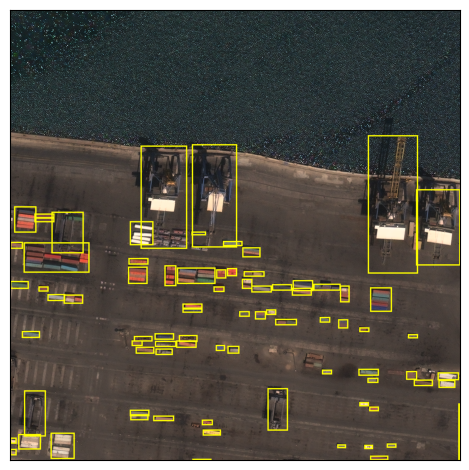

In [60]:
from pathlib import Path
import torchvision.transforms.v2 as v2

tf = v2.Compose(
    [
        #v2.ToImage(),
        v2.RandomCrop(1000),
        #v2.RandomPhotometricDistort(p=1),
        #v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        #v2.RandomIoUCrop(),
        #v2.RandomHorizontalFlip(p=1),
        v2.SanitizeBoundingBoxes(),
        #v2.ToDtype(torch.float32, scale=True),
    ]
)

xview = Path('/data/XVIEW1')
dataset = xView(
    xview/'train_images',
    xview/'xView_train.json',
    transforms=tf
)

plot([dataset[0]])